<a href="https://colab.research.google.com/github/chlai1012/ML-project/blob/chlai_colab/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Prepare training data**

In [2]:
!wget --no-check-certificate \
    "https://github.com/chlai1012/ML-project/archive/refs/heads/chlai_folder_correct.zip" \
    -O "/tmp/ML-project-chlai_folder_correct.zip"

zip_ref = zipfile.ZipFile('/tmp/ML-project-chlai_folder_correct.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-08-14 08:35:44--  https://github.com/chlai1012/ML-project/archive/refs/heads/chlai_folder_correct.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/chlai1012/ML-project/zip/refs/heads/chlai_folder_correct [following]
--2021-08-14 08:35:44--  https://codeload.github.com/chlai1012/ML-project/zip/refs/heads/chlai_folder_correct
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/ML-project-chlai_folder_correct.zip’

/tmp/ML-project-chl     [     <=>            ]  22.02M  14.9MB/s    in 1.5s    

2021-08-14 08:35:46 (14.9 MB/s) - ‘/tmp/ML-project-chlai_folder_correct.zip’ saved [23085415]



In [ ]:
hsLen = len(os.listdir('/tmp/ML-project-chlai_folder_correct/Heat source/Data'))
gtLen = len(os.listdir('/tmp/ML-project-chlai_folder_correct/Ground truth/Data'))

print('Heat source: ' , hsLen) # Get sample length from folders
print('Ground truth: ' , gtLen)

Heat source:  121
Ground truth:  121


In [34]:
image_generator = ImageDataGenerator()

# fixed RNG seed to make sure images and masks are transformed in the same way
seed = 42

hs_iterator = image_generator.flow_from_directory("/tmp/ML-project-chlai_folder_correct/Heat source",
                          class_mode=None,
                          batch_size=16, 
                          seed=seed)

gt_iterator = image_generator.flow_from_directory("/tmp/ML-project-chlai_folder_correct/Ground truth",
                          class_mode=None,
                          batch_size=16, 
                          seed=seed)

train_iterator = zip(hs_iterator, gt_iterator)

Found 121 images belonging to 1 classes.
Found 121 images belonging to 1 classes.


In [4]:
hs, gt= next(train_iterator)
hs.shape

(16, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

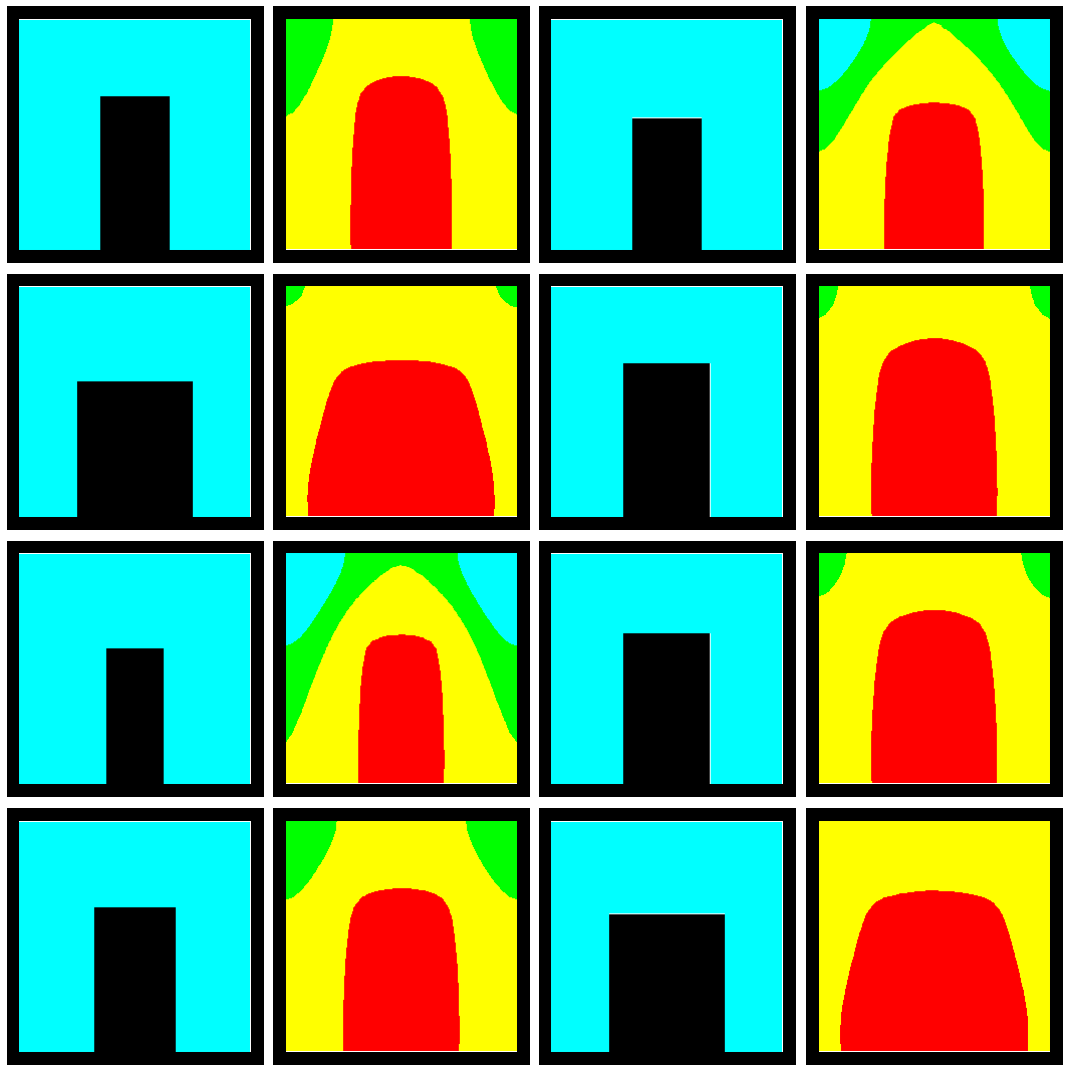

In [35]:
fig,axs = plt.subplots(4,4, figsize=(15,15))
axs = axs.flatten()

hs, gt= next(train_iterator)

for i in range(8):
    axs[2*i].imshow(hs[i])
    axs[2*i+1].imshow(gt[i])
    
for ax in axs:
    ax.axis("off")

plt.tight_layout()

# **CNN** traingin model

In [6]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session

In [63]:
#@title Custom call back function
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class CustomCallback(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        

    def on_epoch_end(self, epoch, logs={}):
        self.x.append(epoch)
        self.losses.append(logs["loss"])
        #self.val_losses.append(logs["val_loss"])
        
        clear_output(wait=True)
        
        fig, axs = plt.subplots(1,2, figsize=(16,7))
        
        axs[0].plot(self.x, self.losses, lw=4, label="loss")
        #axs[0].plot(self.x, self.val_losses, lw=4, label="val_loss")
        axs[0].legend(fontsize=16)
        axs[0].set_xlabel("Epoch", fontsize=16)
        axs[0].set_ylabel("Loss", fontsize=16)
        #axs[0].set_yscale("log")
        
        plt.show()
        
        # place your conditional statement here
        # it should check whether the current loss is below 3.3*10^-3 and then
        # set self.model.stop_training to True
        # you can additionally provide a print() statement
        if logs["loss"] < 3.3e-3:
            print(f"Loss < 3.3e-3, stopping training early at epoch {epoch}")
            self.model.stop_training = True
        
customCallback = CustomCallback()

In [64]:

clear_session()

input_dim = hs.shape[1:]

model = Sequential()

# Encoder layers
model.add(Conv2D(64,(3,3),activation='relu',padding="same",input_shape=input_dim))
model.add(MaxPooling2D((2,2),padding="same"))
model.add(Conv2D(128,(3,3),activation='relu',padding="same"))
model.add(MaxPooling2D((2,2),padding="same"))
model.add(Conv2D(256,(3,3),strides=(2,2),activation='relu',padding="same"))

# Flatten encoding for visualization, this is the bottleneck
model.add(Flatten())
model.add(Reshape((32, 32, 256)))

# Decoder layers
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(128,(3,3),activation='relu',padding="same"))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu',padding="same"))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(3,(3,3),activation='relu',padding="same"))


model.summary()
#plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 256)       0

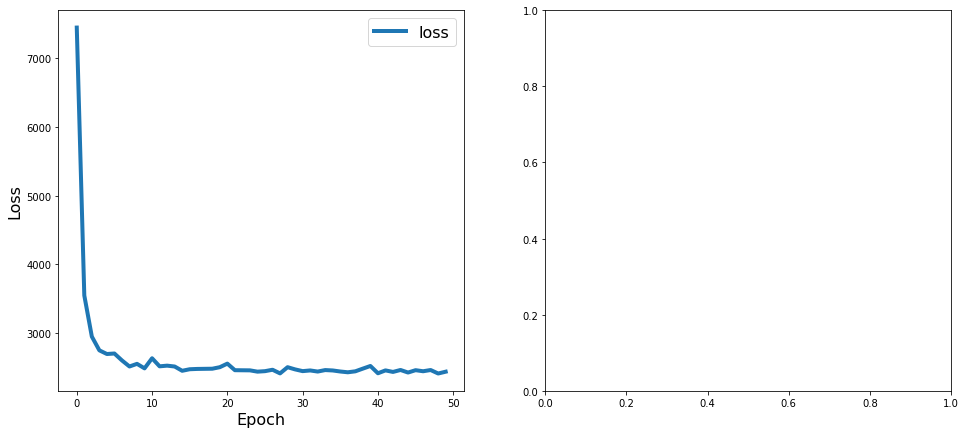

In [65]:
model.compile(optimizer='adam', loss='mse')
model.fit(
      train_iterator,
      batch_size=16,
      epochs=50,
      steps_per_epoch=32,
      shuffle=True,
      verbose=1,
      callbacks=customCallback)

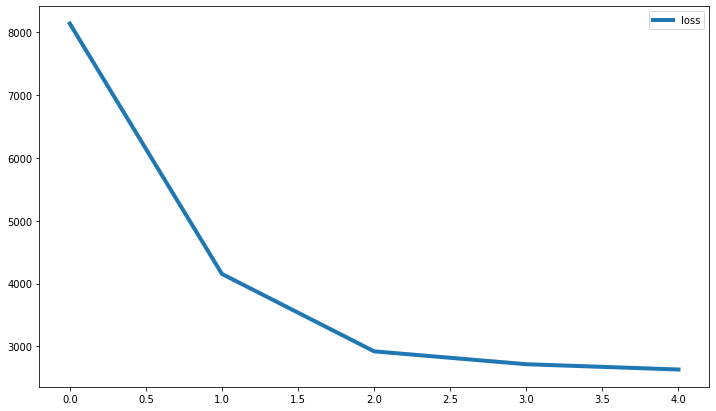

In [46]:
history = model.history

plt.figure(figsize=(12,7))

plt.plot(history.history["loss"], lw=4, label="loss")

plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

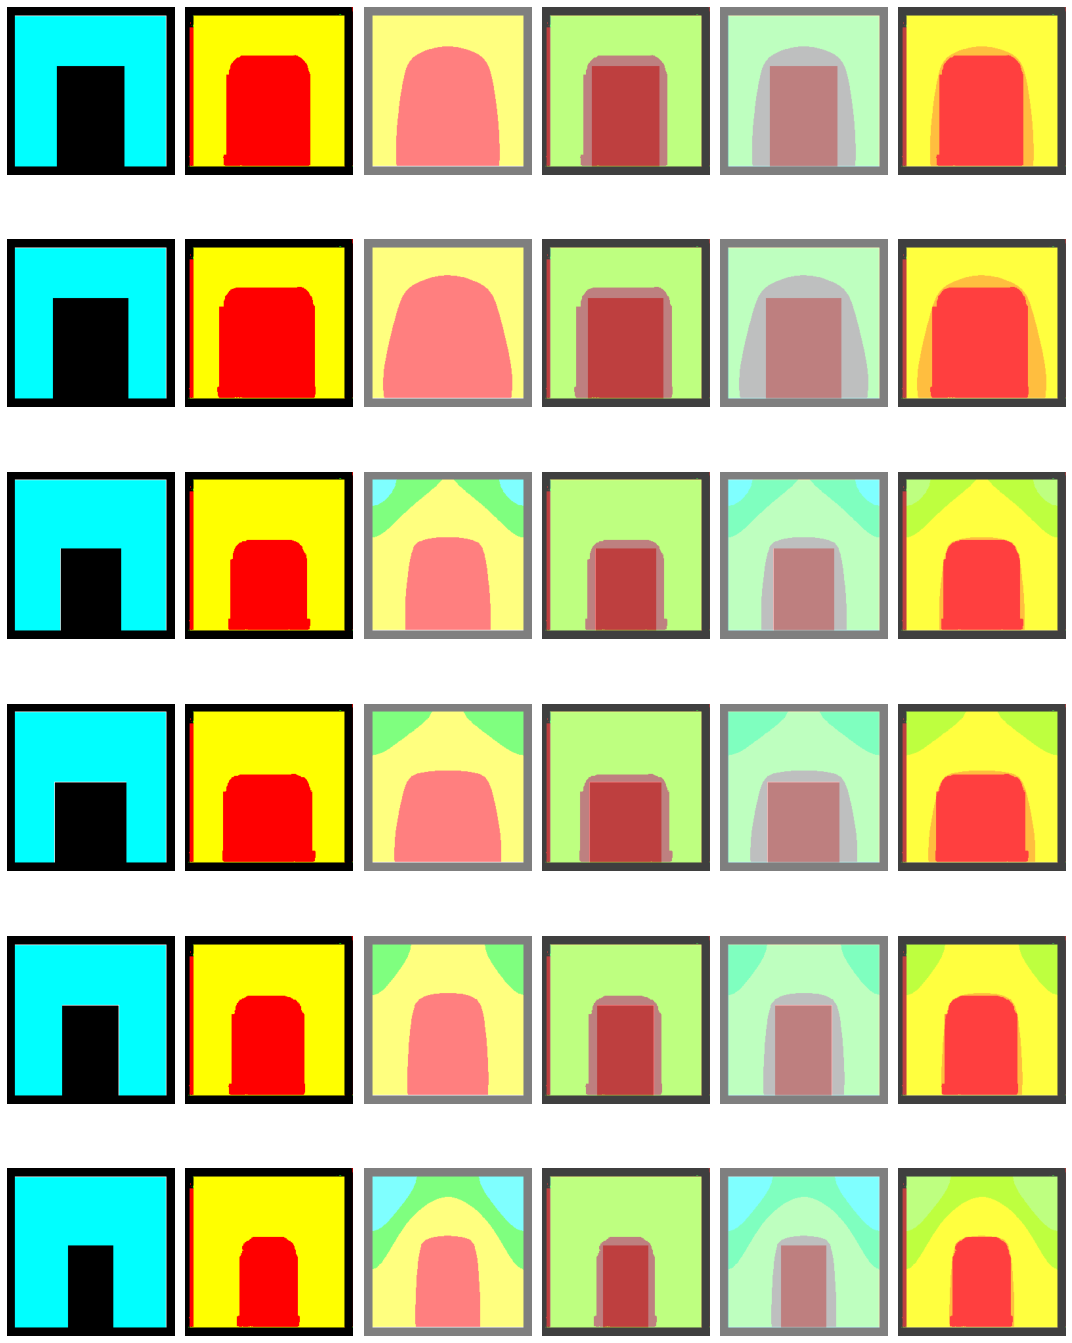

In [66]:
samples = 6

fig,axs = plt.subplots(samples,6, figsize=(15,20))

gt_hat = model.predict(hs.reshape(-1,256,256,3))

for sample in range(samples):
    axs[sample,0].imshow(hs[sample])
    axs[sample,1].imshow(gt_hat[sample].reshape(256,256,3))
    axs[sample,2].imshow((gt[sample]+1)/2)
    axs[sample,3].imshow((hs[sample]+1)/2)
    axs[sample,3].imshow(gt_hat[sample].reshape(256,256,3),alpha=0.5)
    axs[sample,4].imshow((hs[sample]+1)/2)
    axs[sample,4].imshow((gt[sample]+1)/2,alpha=0.5)
    axs[sample,5].imshow((gt[sample]+1)/2)
    axs[sample,5].imshow(gt_hat[sample].reshape(256,256,3),alpha=0.5)
    
axs=axs.flatten()

for ax in axs:
    ax.axis("off")
    
plt.tight_layout()

# **CNN using pretrained model**

refer: https://www.tensorflow.org/tutorials/images/transfer_learning

In [36]:
# Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

IMG_SIZE = (256, 256)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

hs, gt= next(train_iterator)
feature_batch = base_model(hs)
print(feature_batch.shape)

(16, 8, 8, 1024)


In [37]:
# Freeze the convolutional base
base_model.trainable = False
#base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(16, 1024)


In [38]:
# Build model
inputs = tf.keras.Input(shape=(256, 256, 3))
x = Sequential()
x = x(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Flatten()(x)
x = Reshape((16,16,4))(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(32,(3,3),activation='relu',padding="same")(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu',padding="same")(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(3,(3,3),activation='linear',padding="same")(x)
outputs = UpSampling2D(size=(2,2))(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
len(model.trainable_variables)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_13 (Sequential)   multiple                  0         
_________________________________________________________________
tf.math.truediv_13 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_13 (TFOpLam (None, 256, 256, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024)              0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


6

In [39]:
model.fit(
      train_iterator,
      batch_size=16,
      epochs=5,
      steps_per_epoch=32,
      verbose=1)

Epoch 1/5
32/32 [==============================] - 13s 235ms/step - loss: -18.0084 - accuracy: 0.3781
Epoch 2/5
32/32 [==============================] - 8s 237ms/step - loss: -89.0069 - accuracy: 0.5226
Epoch 3/5
32/32 [==============================] - 8s 241ms/step - loss: -263.2429 - accuracy: 0.6513
Epoch 4/5
32/32 [==============================] - 8s 247ms/step - loss: -656.6340 - accuracy: 0.7178
Epoch 5/5
32/32 [==============================] - 8s 244ms/step - loss: -1433.1140 - accuracy: 0.7221


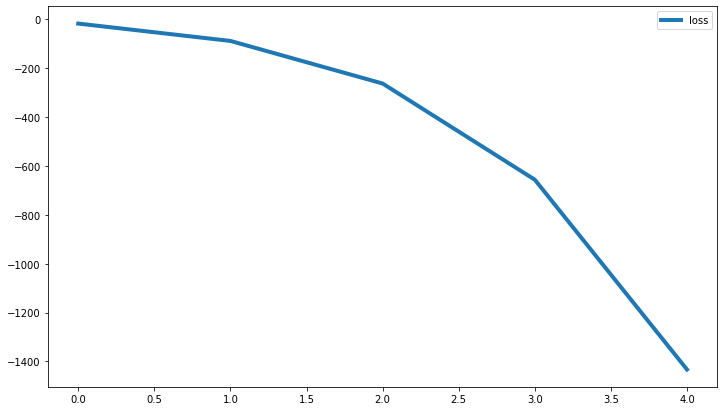

In [40]:
history = model.history

plt.figure(figsize=(12,7))

plt.plot(history.history["loss"], lw=4, label="loss")

plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

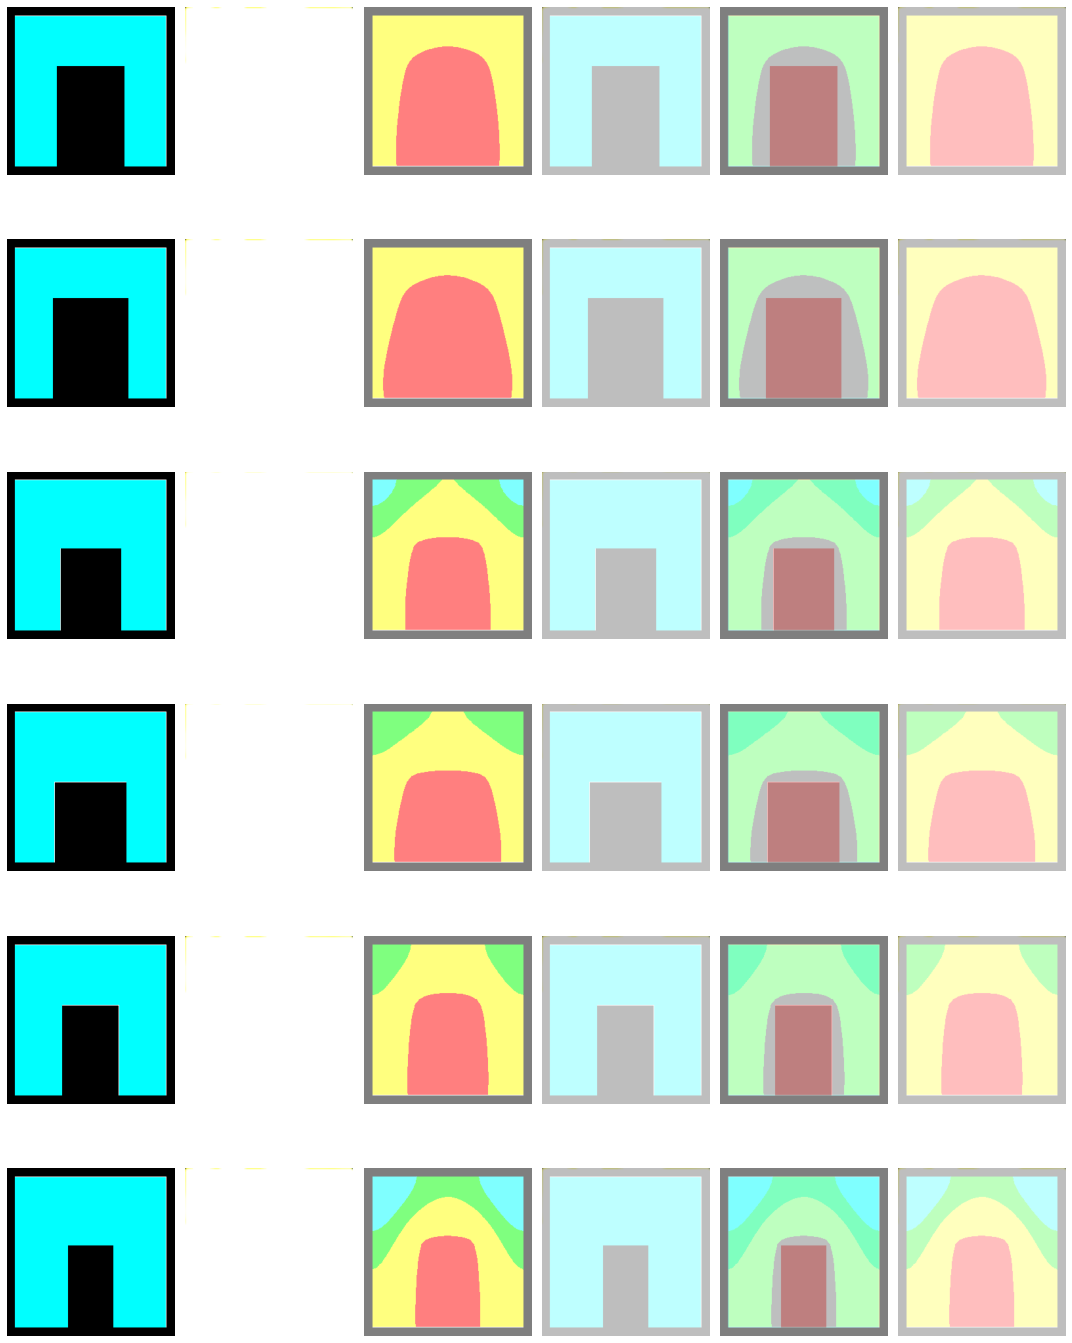

In [41]:
samples = 6

fig,axs = plt.subplots(samples,6, figsize=(15,20))

gt_hat = model.predict(hs.reshape(-1,256,256,3))

for sample in range(samples):
    axs[sample,0].imshow(hs[sample])
    axs[sample,1].imshow(gt_hat[sample].reshape(256,256,3))
    axs[sample,2].imshow((gt[sample]+1)/2)
    axs[sample,3].imshow((hs[sample]+1)/2)
    axs[sample,3].imshow(gt_hat[sample].reshape(256,256,3),alpha=0.5)
    axs[sample,4].imshow((hs[sample]+1)/2)
    axs[sample,4].imshow((gt[sample]+1)/2,alpha=0.5)
    axs[sample,5].imshow((gt[sample]+1)/2)
    axs[sample,5].imshow(gt_hat[sample].reshape(256,256,3),alpha=0.5)
    
axs=axs.flatten()

for ax in axs:
    ax.axis("off")
    
plt.tight_layout()